Good Day! This is Anika. The optional critetion included TOPSIS part is done in a markdown cell as I had to use custom criterion weight. **please uncomment the code while checking that particular block.**
dataset: https://files.mobilitydatabase.org/mdb-2818/mdb-2818-202508181629/mdb-2818-202508181629.zip

In [37]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [38]:
data_folder=r"..\mdb-2818-202508181629"

In [39]:
routes= pd.read_csv(f"{data_folder}/routes.txt")
trips= pd.read_csv(f"{data_folder}/trips.txt")
stop_times = pd.read_csv(f"{data_folder}/stop_times.txt")
shapes = pd.read_csv(f"{data_folder}/shapes.txt")

In [40]:
#Number of Trips
trip_count = trips.groupby("route_id")["trip_id"].nunique().rename("trip_count")
trip_count.head()

route_id
1    40
2    78
3    20
4    12
8    42
Name: trip_count, dtype: int64

In [41]:
#Code for travel length calculation
shapes["shape_pt_lat"] = pd.to_numeric(shapes["shape_pt_lat"], errors="coerce")
shapes["shape_pt_lon"] = pd.to_numeric(shapes["shape_pt_lon"], errors="coerce")
shapes["shape_pt_sequence"] = pd.to_numeric(shapes["shape_pt_sequence"], errors="coerce")
#to omit NaaN
def haversine(lat1,lon1,lat2,lon2):
    R=6371 # Earth's radius
    lat1,lon1,lat2,lon2= map(np.radians,[lat1,lon1,lat2,lon2])
    delta_lat= lat2-lat1
    delta_lon= lon2-lon1
    a = np.sin(delta_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))
#haversine function
def compute_shape_distance(g):
    lat = pd.to_numeric(g["shape_pt_lat"], errors="coerce").to_numpy()
    lon = pd.to_numeric(g["shape_pt_lon"], errors="coerce").to_numpy()
    mask = ~np.isnan(lat) & ~np.isnan(lon)#Cleaning empty cells
    lat, lon = lat[mask], lon[mask]
    if len(g) < 2:
        return 0
    else:
        lat = g["shape_pt_lat"].to_numpy()
        lon = g["shape_pt_lon"].to_numpy()
        total_km = 0.0
        for i in range(1, len(g)):
            total_km += haversine(lat[i-1], lon[i-1], lat[i], lon[i])
        return total_km

In [42]:
shape_distances = (
    shapes.groupby("shape_id", group_keys=False)
          .apply(compute_shape_distance)
          .reset_index(name="shape_length_km")
)
shape_distances.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_24700\3910880004.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_shape_distance)


,shape_id,shape_length_km
0,001_L1_T5_I,2.816249
1,001_L1_T7_I,11.414416
2,001_L1_T8_I,12.377780
3,001_L1_T9_I,9.698295
4,002_L2_T5_I,8.373535


In [43]:
#Average distance for each trip per route
trips_with_distance = trips.merge(
    shape_distances,
    on="shape_id",
    how="left"
)
trips_with_distance.head()
avg_distance_per_route = trips_with_distance.groupby("route_id")["shape_length_km"].mean()
avg_distance_per_route = avg_distance_per_route.rename("Average_Route_Distance")
avg_distance_per_route.head()



route_id
1    11.573057
2     5.543055
3    12.048556
4     6.436929
8     5.645298
Name: Average_Route_Distance, dtype: float64

In [44]:
#Headway
def avg_headway(route_id):
    trip_ids = trips[trips["route_id"] == route_id]["trip_id"]
    times = []
    for t in trip_ids:
        r = stop_times[(stop_times["trip_id"] == t) & (stop_times["stop_sequence"] == 1)]
        if r.empty: 
            continue
        h,m,s = map(int, str(r.iloc[0]["departure_time"]).split(":"))
        times.append(h*3600 + m*60 + s)#conversion to second
    times.sort()
    if len(times) <= 1:
        return np.nan
    else:
        gaps_in_seconds = np.diff(times)
        average_gap_seconds = np.mean(gaps_in_seconds)
        average_gap_minutes = average_gap_seconds / 60
        return average_gap_minutes
headway_dict = {}
for route_id in trip_count.index:
    headway_dict[route_id] = avg_headway(route_id)
headway = pd.DataFrame(list(headway_dict.items()), columns=["route_id", "avg_headway_min"])
print(headway.head())

   route_id  avg_headway_min
0         1        22.717949
1         2        11.298701
2         3        47.736842
3         4        36.363636
4         8        20.048780


In [45]:
#summary table :)
summary = routes.merge(trip_count, on="route_id").merge(avg_distance_per_route, on="route_id") .merge(headway, on="route_id")
summary = summary[[
    "route_id",
    "route_short_name",
    "route_long_name",
    "trip_count",
    "Average_Route_Distance",
    "avg_headway_min"
]]
summary.head()

,route_id,route_short_name,route_long_name,trip_count,Average_Route_Distance,avg_headway_min
0,1,L1,Centro / Pajaritos / Royales / Centro / San Pe...,40,11.573057,22.717949
1,2,L2,Centro / Est Autobuses / Barriada / Tejera / S...,78,5.543055,11.298701
2,3,L3,Centro / Royales / Pajaritos / Centro / San Pe...,20,12.048556,47.736842
3,4,L4,Centro / Hospitales / Est. Autobuses / Centro,12,6.436929,36.363636
4,8,C,CIRCULAR - Festivos - El Salvador/Barriada/Tej...,42,5.645298,20.048780


In [46]:
#TOPSIS Prep
topsis_data = summary[["route_id", "trip_count", "Average_Route_Distance", "avg_headway_min"]].copy()
topsis_data=topsis_data.rename(columns={"trip_count":"daily_ridership"})

In [47]:
#random generation of data for evelation and equity index
np.random.seed(100)
topsis_data["elevation_gain_m"] = np.random.randint(10, 100, size=len(topsis_data))
topsis_data["equity_index"] = np.random.uniform(0.2, 0.9, size=len(topsis_data))
topsis_data.head()

,route_id,daily_ridership,Average_Route_Distance,avg_headway_min,elevation_gain_m,equity_index
0,1,40,11.573057,22.717949,18,0.203303
1,2,78,5.543055,11.298701,34,0.285098
2,3,20,12.048556,47.736842,77,0.669524
3,4,12,6.436929,36.363636,97,0.778097
4,8,42,5.645298,20.048780,89,0.295695


In [48]:
weights = [0.30, 0.25, 0.25, 0.20]
bc = [1, 0, 0, 1] #1=benefit criteria, 0= cost criteria

In [49]:
#TOPSIS ALGO
x=topsis_data[["daily_ridership", "Average_Route_Distance", "elevation_gain_m", "equity_index"]].to_numpy()
normalized= np.sqrt((x**2).sum(axis=0))
R=x/normalized
w=np.array(weights)
v=R*w
ideal_best = np.max(v, axis=0)
ideal_worst = np.min(v, axis=0)
#reversal for cost criteria
for i, b in enumerate(bc):
    if b == 0: 
        ideal_best[i], ideal_worst[i] = ideal_worst[i], ideal_best[i]
d_plus = np.sqrt(((v - ideal_best) ** 2).sum(axis=1))
d_minus = np.sqrt(((v - ideal_worst) ** 2).sum(axis=1))
c=d_minus/(d_plus+d_minus)

topsis_data["Score"]=c
topsis_data["Rank"]=topsis_data["Score"].rank(ascending=True)

topsis_data_sorted=topsis_data.sort_values("Rank")
topsis_data_sorted.head()


,route_id,daily_ridership,Average_Route_Distance,avg_headway_min,elevation_gain_m,equity_index,Score,Rank
5,9,4,9.584254,153.333333,58,0.602565,0.260002,1.0
2,3,20,12.048556,47.736842,77,0.669524,0.286984,2.0
3,4,12,6.436929,36.363636,97,0.778097,0.301991,3.0
6,12,10,8.968036,11.111111,20,0.823925,0.413189,4.0
4,8,42,5.645298,20.048780,89,0.295695,0.445851,5.0


In [50]:
topsis_data_sorted.to_csv("Topsis rank.csv",index=False)

In [51]:
print("R shape:", R.shape)
print("w shape:", w.shape)

R shape: (7, 4)
w shape: (4,)


<function matplotlib.pyplot.show(close=None, block=None)>

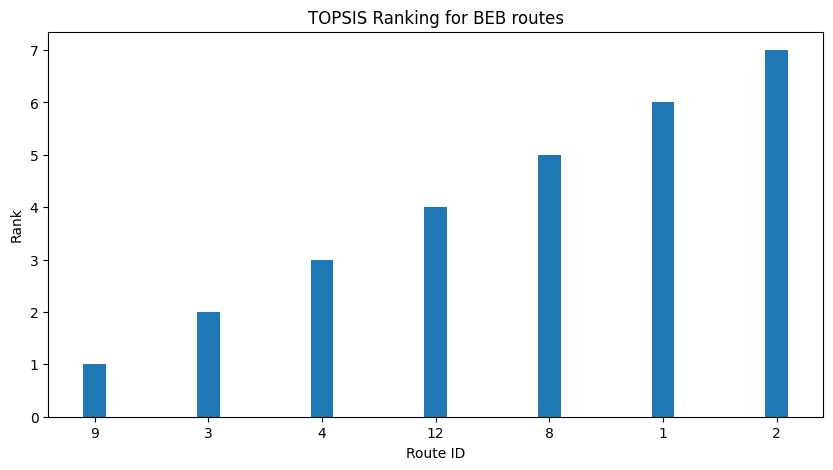

In [52]:
#Visualization
plt.figure(figsize=(10,5))
plt.bar(topsis_data_sorted['route_id'].astype(str),topsis_data_sorted['Rank'],width=0.2)
plt.title("TOPSIS Ranking for BEB routes")
plt.xlabel("Route ID")
plt.ylabel("Rank")
plt.show

In [53]:
# #Optional with extra criterion[Uncomment to run the optional task]
# topsis_data["GHG_savings"] = (topsis_data["Average_Route_Distance"] * topsis_data["daily_ridership"]*0.9)
# Criteria = ["daily_ridership","Average_Route_Distance","elevation_gain_m","equity_index","GHG_savings"]
# x=topsis_data[["daily_ridership","Average_Route_Distance","elevation_gain_m","equity_index","GHG_savings"]].to_numpy()
# normalized= np.sqrt((x**2).sum(axis=0))
# R=x/normalized
# weights = np.array([0.25, 0.20, 0.20, 0.15, 0.20])#assumed weight for GHG savings
# bc2=bc = [1, 0, 0, 1, 1]
# v=R*weights
# ideal_best = np.max(v, axis=0)
# ideal_worst = np.min(v, axis=0)
# #reversal for cost criteria
# for i, b in enumerate(bc2):
#     if b == 0: 
#         ideal_best[i], ideal_worst[i] = ideal_worst[i], ideal_best[i]
# d_plus = np.sqrt(((v - ideal_best) ** 2).sum(axis=1))
# d_minus = np.sqrt(((v - ideal_worst) ** 2).sum(axis=1))
# c=d_minus/(d_plus+d_minus)

# topsis_data["Score"]=c
# topsis_data["Rank"]=topsis_data["Score"].rank(ascending=True)

# topsis_data=topsis_data.sort_values("Rank")
# topsis_data.head()

In [54]:
# #Visualization
# plt.figure(figsize=(10,5))
# plt.bar(topsis_data['route_id'].astype(str),topsis_data['Rank'],width=0.2)
# plt.title("TOPSIS Ranking for BEB routes")
# plt.xlabel("Route ID")
# plt.ylabel("Rank")
# plt.show